# Neural network classification

In [1]:
from sklearn.datasets import make_circles


# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, noise=0.03,random_state=42)

In [2]:
# See data generated

print(f"First 3 X features:\n{X[:3]}")
print(f"\nFirst 3 y labels:\n{y[:3]}")

First 3 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]]

First 3 y labels:
[1 1 1]


In [3]:
# Make DataFrame of circle data

import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [4]:
# Check different labels
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

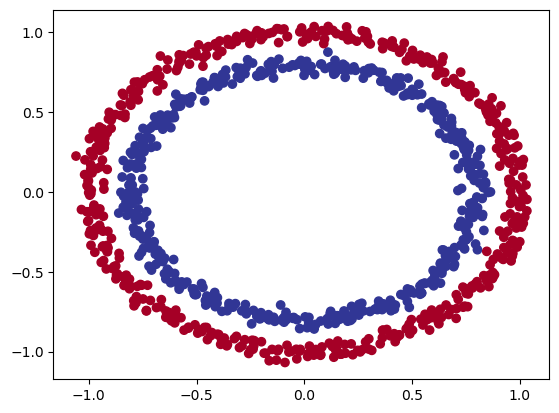

In [5]:
# Visualize with a plot

import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [6]:
# Data to tensors 
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [7]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [8]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Make two layers of model instance and send to device

In [10]:
class Circle_Modelv0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5) 
        self.layer_2 = nn.Linear(in_features=5, out_features=1) 
    
    def forward(self, x):
        return self.layer_2(self.layer_1(x))

model_0 = Circle_Modelv0().to(device)
model_0

Circle_Modelv0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

Note that we are using 5 hidden units. The number of hidden units we 
use in neural network layers is a hyperparameter (a value you can set yourself and tune!).
There is an alternate way of doing what we did above. 

In [11]:
# Replicate Circle_Modelv0 with nn.Sequential

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

Though this is neat compared to above, this runs sequentially. We might not 
always want that. So if we want something else to happen 
we would like to define our own custom nn.Module subclass!

In [12]:
# Make predictions with the model

untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.4827],
        [0.4013],
        [0.4764],
        [0.4853],
        [0.1278],
        [0.0808],
        [0.1280],
        [0.0520],
        [0.4911],
        [0.3920]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


Now, we define loss function and optimizer

In [13]:
# Create a loss function

loss_fn = nn.BCEWithLogitsLoss() # BCE = Binary cross entropy

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [14]:
# Monitor accuracy (a classification metric)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

Our data is non-linear (circles) so we need non-linear activation function. 
One of the most common and best performing is ReLU (rectified linear-unit, torch.nn.ReLU()).

In [15]:
# Build model with non-linear activation function
from torch import nn

class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # Add in ReLU activation function

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV1().to(device)
print(model_3)

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [16]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [17]:
# Fit the model

torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # Logits -> Prediction probabilities -> Prediction labels
    
    # 2. Calculate loss and accuracy
    
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits))
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 200 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69219, Accuracy: 47.25% | Test Loss: 0.69488, Test Accuracy: 48.00%
Epoch: 200 | Loss: 0.68443, Accuracy: 63.38% | Test Loss: 0.68804, Test Accuracy: 60.50%
Epoch: 400 | Loss: 0.67311, Accuracy: 61.00% | Test Loss: 0.68076, Test Accuracy: 54.50%
Epoch: 600 | Loss: 0.64988, Accuracy: 64.88% | Test Loss: 0.66346, Test Accuracy: 58.00%
Epoch: 800 | Loss: 0.58754, Accuracy: 83.25% | Test Loss: 0.60929, Test Accuracy: 78.50%


In [18]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # Need preds in same format as truth labels

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

In [24]:
import numpy as np

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.
    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
# This code is used to view decision boundary from 
# https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

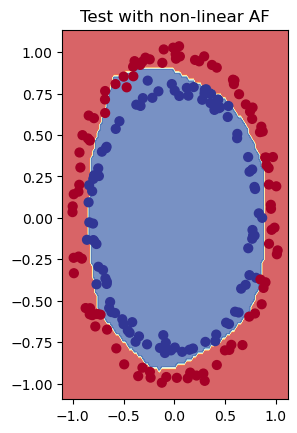

In [25]:
# Plot decision boundaries for training and test sets


plt.subplot(1, 2, 2)
plt.title("Test with non-linear AF")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

# Multi classification 

Recall that a binary classification problem deals with classifying something as one of two options (e.g. a photo as a cat photo or a dog photo) where as a multi-class classification problem deals with classifying something from a list of more than two options (e.g. classifying a photo as a cat a dog or a chicken).

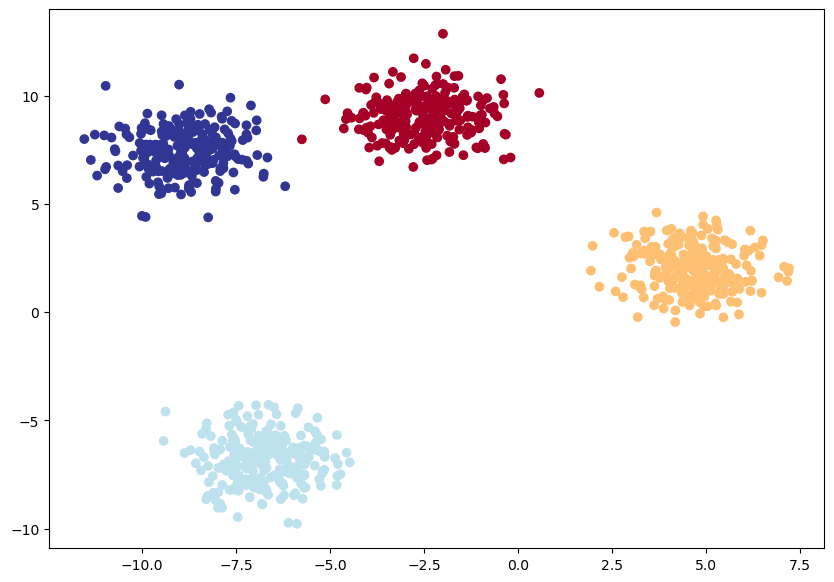

In [26]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.0, 
    random_state=RANDOM_SEED
)

# 2. Turn numpy data into tensors

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,y_blob,test_size=0.2,
                                                                        random_state=RANDOM_SEED
)

# Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [27]:
# Some same old parts 

# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [28]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # For non-linear layers if needed 
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features), 
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

For multi-class classification problem, we'll use the nn.CrossEntropyLoss()

In [29]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

# model_4(X_blob_train.to(device))[:5] # Single forward pass
# Flow: logits -> prediction probabilities -> prediction labels



In [30]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
# Check they sum to 1? 
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5], torch.sum(y_pred_probs[0]))

tensor([[-1.1988, -0.6983, -1.4013, -0.6101],
        [ 1.7765, -1.2490,  1.7994,  2.1650],
        [ 2.2684,  0.7261,  2.6267,  1.0674],
        [-0.8950, -0.4057, -1.0242, -0.5896],
        [-0.2137, -1.5658, -0.4404,  0.8248]], grad_fn=<SliceBackward0>)
tensor([[0.1898, 0.3131, 0.1550, 0.3420],
        [0.2820, 0.0137, 0.2885, 0.4158],
        [0.3395, 0.0726, 0.4858, 0.1021],
        [0.2055, 0.3351, 0.1806, 0.2789],
        [0.2049, 0.0530, 0.1633, 0.5788]], grad_fn=<SliceBackward0>) tensor(1., grad_fn=<SumBackward0>)


Creating a training and testing loop for a multi-class PyTorch model

In [31]:
# Fit the model
torch.manual_seed(42)

epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out steps 
    if epoch % 20 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.03702, Acc: 68.50% | Test Loss: 0.56405, Test Acc: 99.00%
Epoch: 20 | Loss: 0.04924, Acc: 99.88% | Test Loss: 0.04515, Test Acc: 100.00%
Epoch: 40 | Loss: 0.02171, Acc: 99.88% | Test Loss: 0.01930, Test Acc: 100.00%
Epoch: 60 | Loss: 0.01389, Acc: 99.88% | Test Loss: 0.01182, Test Acc: 100.00%
Epoch: 80 | Loss: 0.01033, Acc: 99.88% | Test Loss: 0.00843, Test Acc: 100.00%


Seems to be doing alright! 

In [32]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 5 predictions
y_logits[:5]

tensor([[  3.7826,   9.6491, -13.3450,  -9.3730],
        [  4.6158, -11.4566,   3.4186,  10.4919],
        [ -5.3788, -13.3182,  20.4723,  13.1327],
        [  2.1570,   7.7691,  -9.2223,  -7.4535],
        [  7.4186,   2.1213, -12.5309,  -2.5824]])

In [34]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 20 model preds and test labels
print(f"Predictions: {y_preds[:20]}\nLabels: {y_blob_test[:20]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3])
Test accuracy: 100.0%


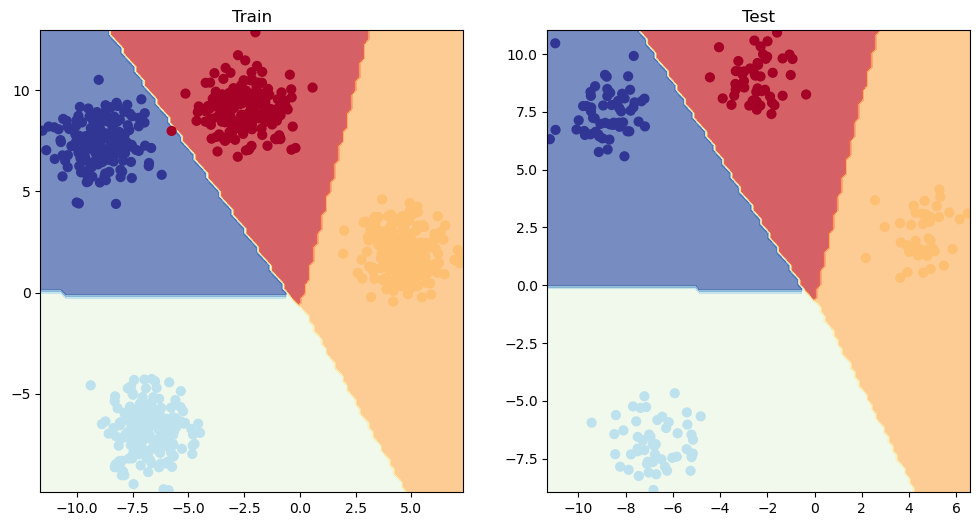

In [35]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

# What if we had used nn.ReLU() ? 

In [39]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(), # For non-linear layers if needed 
            nn.ReLU(),
            #nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features), 
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): ReLU()
    (3): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [40]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

In [41]:
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
# Check they sum to 1? 
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5], torch.sum(y_pred_probs[0]))

tensor([[-0.0899, -0.2019, -0.1344, -0.6498],
        [-0.7147, -0.9651, -0.6813, -0.5658],
        [-1.0129, -2.1992, -0.5460, -0.6910],
        [ 0.2949, -0.0565,  0.0075, -0.5555],
        [-0.4954, -0.3193,  0.1830, -0.7376]], grad_fn=<SliceBackward0>)
tensor([[0.2922, 0.2613, 0.2795, 0.1669],
        [0.2517, 0.1959, 0.2602, 0.2921],
        [0.2336, 0.0713, 0.3727, 0.3224],
        [0.3471, 0.2442, 0.2604, 0.1483],
        [0.2021, 0.2410, 0.3983, 0.1586]], grad_fn=<SliceBackward0>) tensor(1.0000, grad_fn=<SumBackward0>)


In [42]:
# Fit the model
torch.manual_seed(42)

epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out steps 
    if epoch % 20 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.30680, Acc: 38.12% | Test Loss: 0.73553, Test Acc: 99.00%
Epoch: 20 | Loss: 0.06289, Acc: 99.88% | Test Loss: 0.05817, Test Acc: 100.00%
Epoch: 40 | Loss: 0.03030, Acc: 99.88% | Test Loss: 0.02792, Test Acc: 100.00%
Epoch: 60 | Loss: 0.02006, Acc: 99.88% | Test Loss: 0.01814, Test Acc: 100.00%
Epoch: 80 | Loss: 0.01513, Acc: 99.88% | Test Loss: 0.01338, Test Acc: 100.00%


In [43]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)


In [44]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 20 model preds and test labels
print(f"Predictions: {y_preds[:20]}\nLabels: {y_blob_test[:20]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3])
Test accuracy: 100.0%


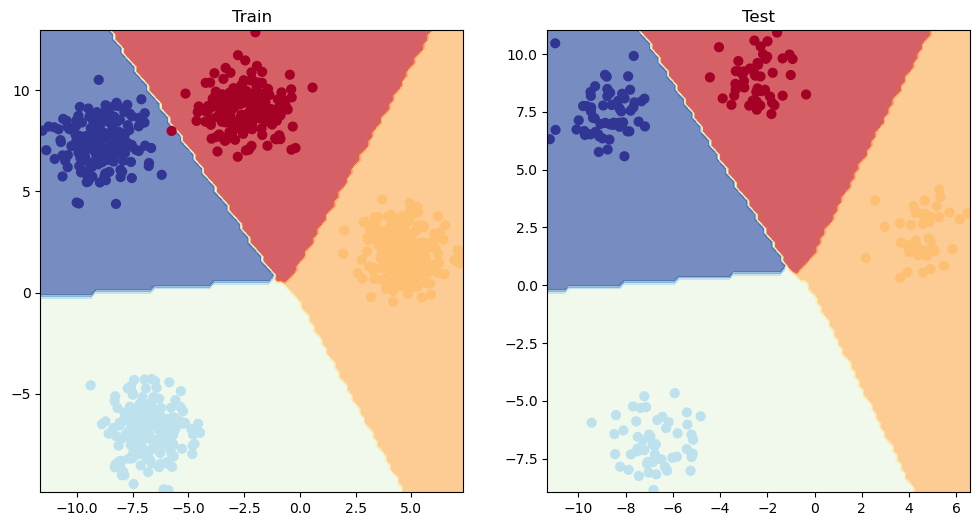

In [45]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

We see that there is not much difference. We don't really need non-linear parts here. Well-known activation functions used in data science include the rectified linear unit (ReLU) function, and the family of sigmoid functions such as the logistic sigmoid function, the hyperbolic tangent, and the arctangent function. Two commonly used activation functions: the rectified linear unit (ReLU) and the logistic sigmoid function. The ReLU has a hard cutoff at 0 where its behavior changes, while the sigmoid exhibits a gradual change. Both tend to 0 for small x, and the sigmoid tends to 1 for large x.